In [1]:
import pandas as pd
import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy

pjoin = os.path.join

In [20]:
def resoftmax(a):
    a = np.log(a + 1e-9)
    a -= np.max(a, axis=1, keepdims=True)
    exp_ = np.exp(a)
    sum_ = np.sum(exp_, axis=1, keepdims=True)
    return exp_ / sum_

def gauss2(cx, cy, cxm, cym, cxd, cyd):
    cxd = max(1, cxd)
    cyd = max(1, cyd)
    x_ = ((cx-cxm)/cxd)**2
    y_ = ((cy-cym)/cyd)**2
    return np.exp(-0.5*(x_ + y_)) / (2.*np.pi*cxd*cyd)

def penalize_dist(cls_prob, cx, cy, cxm, cym, rm):
    k = 2.
    d = np.sqrt((cx-cxm)**2 + (cy-cym)**2)
    return cls_prob * (d < k*rm)[:,None]
# def penalize_dist(cls_prob, cx, cy, cxm, cym, cxd, cyd, rm):
#     k = .5
#     cxd = max(1, cxd)
#     cyd = max(1, cyd)
#     r = ((cx-cxm)/cxd)**2 + ((cy-cym)/cyd)**2
#     return cls_prob * np.exp(-k*cls_prob*r[:,None])

In [3]:
run = '27-10-2017-1148'
res_dir = pjoin('train_logs', run, 'results')

fish_number_method = 'prob'
if fish_number_method == 'prob':
    fish_rate_dist = np.load('data/fish_rate_distribution.npy')[:200]
    
fish_number_col = 3

In [4]:
frame_count_df = pd.read_csv('data/test_video_frame_count.csv')
assert frame_count_df.frames.sum() == 918504
frame_count = dict(zip(frame_count_df.video_id, frame_count_df.frames))
test_video_ids = frame_count.keys()

In [5]:
pred_df_map_o = {}
for fn in os.listdir(res_dir):
    if not 'test_videos_' in fn:
        print 'ignoring ', fn
        continue
    video_id = os.path.splitext(fn)[0].split('test_videos_')[-1]
    pred_df_map_o[video_id] = pd.read_csv(os.path.join(res_dir, fn))
    
assert set(pred_df_map_o.keys()) == set(test_video_ids)

In [22]:
# Fix predictions

pred_df_map = deepcopy(pred_df_map_o)

num_fish_map = {} # for debug
next_fish_frames_list = [] # for debug
fish1_frames_list = [] # for debug

#for video_id in ['Aa831si72EQnAfA9']:
for video_id in test_video_ids:
    # fix number of frames in predictions
    fc = frame_count[video_id]
    pred_rows = pred_df_map[video_id].shape[0]
    if pred_rows < fc:
        print 'fixing {} rows: {} vs {}'.format(video_id, pred_rows, fc)
        new_frames = range(fc)
        pred_df_map[video_id] = pred_df_map[video_id].reindex(index=new_frames, fill_value=0)
        print pred_df_map[video_id].shape
        pred_df_map[video_id].frame = new_frames
        pred_df_map[video_id].video_id = [video_id] * fc
    elif pred_rows > fc:
        print 'fixing {} rows: {} vs {}'.format(video_id, pred_rows, fc)
        pred_df_map[video_id] = pred_df_map[video_id].reindex(index=range(fc))
        print pred_df_map[video_id].shape
        
    cls_prob = pred_df_map[video_id].iloc[:,-7:].values
    
    # detect ruler position and rank detections accorting to their proximity
    max_prob = cls_prob.max(axis=1)
    hprob_mask = max_prob > 0.7
    if not np.any(hprob_mask):
        hprob_mask = max_prob > 0.3
    hcx = pred_df_map[video_id].iloc[hprob_mask, 5].values
    hcy = pred_df_map[video_id].iloc[hprob_mask, 6].values
    xb, xe = np.histogram(hcx, bins=1280/32, range=[0, 1280])
    yb, ye = np.histogram(hcy, bins=720/32, range=[0, 1280])
    #print xe[xb.argmax()]
    #print ye[yb.argmax()]
    #print yb
    hr = 0.5 * pred_df_map[video_id].iloc[hprob_mask, 4].values
    #cxm, cxd = hcx.mean(), hcx.std()
    #cym, cyd = hcy.mean(), hcy.std()
    cxm = xe[xb.argmax()]
    cym = ye[yb.argmax()]
    rm = hr.mean()
    cx = pred_df_map[video_id].iloc[:, 5].values
    cy = pred_df_map[video_id].iloc[:, 6].values
    #dist_prob = gauss2(cx, cy, cxm, cym, cxd, cyd)
    cls_prob = penalize_dist(cls_prob, cx, cy, cxm, cym, rm)
    #print cxm, cxd
    #print cym, cyd
    #print rm
    
    # Threshold low probabilities
    max_prob = cls_prob.max(axis=1)
    lprob_thr = 0.3
    lprob_mask = max_prob < lprob_thr
    cls_prob[lprob_mask, :] = 0.
    # re-softmax probabilites (they don't sum up to 1)
    cls_prob[~lprob_mask] = resoftmax(cls_prob[~lprob_mask])
    
    pred_df_map[video_id].iloc[:, -7:] = cls_prob
    fin_max_prob = cls_prob.max(axis=1)
        
    if fish_number_method == 'synth':
        # fill fish sequence
        fish_rate = 21
        num_fish = int(fc/fish_rate) + int(fc%fish_rate)
        fish_sequence = np.repeat(np.arange(1, num_fish+1), fish_rate)[:fc]
        pred_df_map[video_id].fish_number = fish_sequence.astype(np.float64)
        num_fish_map[video_id]=num_fish
    else:
        # find the first fish frame
        # skip leading zero detections
        for lz in range(len(lprob_mask)):
            if not lprob_mask[lz]:
                break
        if lz == len(lprob_mask) - 1:
            pred_df_map[video_id].iloc[:,fish_number_col] = 1.
            continue
        # skip first detections
        for ld in range(lz, len(lprob_mask)):
            if lprob_mask[ld]:
                break
        if ld == len(lprob_mask) - 1:
            pred_df_map[video_id].iloc[:,fish_number_col] = 1.
            continue
        
        fish1_frame = fin_max_prob[:ld].argmax()
        fish1_frames_list.append(fish1_frame)
        # count the rest
        key_frames = [fish1_frame]
        while True:
            fr = key_frames[-1]
            if fr == fc-1:
                break
            to = min(fc-1, fr + len(fish_rate_dist))
            #print fr,to
            #print fin_max_prob[fr:to]
            next_step = (fin_max_prob[fr:to] * fish_rate_dist[:to-fr]).argmax()
            if next_step == 0:
                if to == fc-1:
                    break
                for lz in range(to, fc):
                    if fin_max_prob[lz] > 0:
                        break
                if lz == fc - 1:
                    break
                next_step = lz - fr
            #print next_step, fin_max_prob[fr+next_step]
            next_fish_frame = fr + next_step
            next_fish_frames_list.append(next_step)
            key_frames.append(next_fish_frame)
#         print key_frames

        pred_df_map[video_id].iloc[:key_frames[0],fish_number_col] = 1
        pred_df_map[video_id].iloc[key_frames[-1]:,fish_number_col] = len(key_frames)
        for i in range(len(key_frames)-1):
            pred_df_map[video_id].iloc[key_frames[i]:key_frames[i+1],fish_number_col] = i + 1
            
        assert pred_df_map[video_id].iloc[:,fish_number_col].isnull().sum() == 0
        assert pred_df_map[video_id].iloc[-1,fish_number_col] == len(key_frames), video_id
        
        num_fish_map[video_id]=len(key_frames)
    
        
pred_df = pd.concat(pred_df_map.values(), ignore_index=True)
assert pred_df.shape[0] == 918504

fixing P3QkoeOjxoM6pDKb rows: 87 vs 259
(259, 14)
fixing pGd0FSJQcDH5DI8x rows: 875 vs 876
(876, 14)
fixing bc6hkwua3iLReunk rows: 1576 vs 1577
(1577, 14)
fixing LU2DSX6VZcIsiyaW rows: 1285 vs 1286
(1286, 14)
fixing Sw0AgnH8BY1BDGHu rows: 555 vs 556
(556, 14)
fixing 8jkQWJWPCtIvcnmH rows: 1129 vs 1130
(1130, 14)
fixing tJinkrdMMZ477RGi rows: 429 vs 426
(426, 14)
fixing ZU6XtvFk0UMrHLEL rows: 2266 vs 2267
(2267, 14)


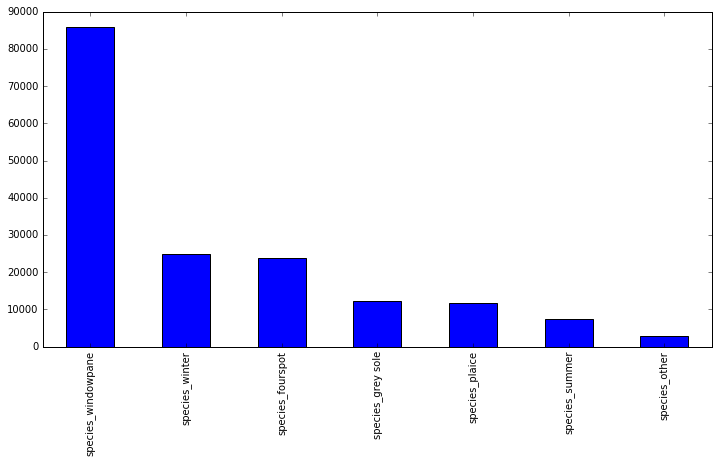

In [23]:
plt.figure(figsize=(12,6))
pred_df.iloc[:,-7:].sum().sort_values(ascending=False).plot(kind='bar')

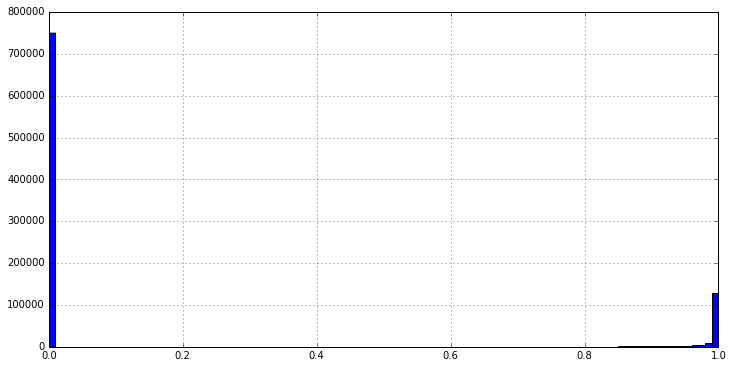

In [24]:
plt.figure(figsize=(12,6))
pred_df.iloc[:,-7:].max(axis=1).hist(bins=100)

min 0
max 487


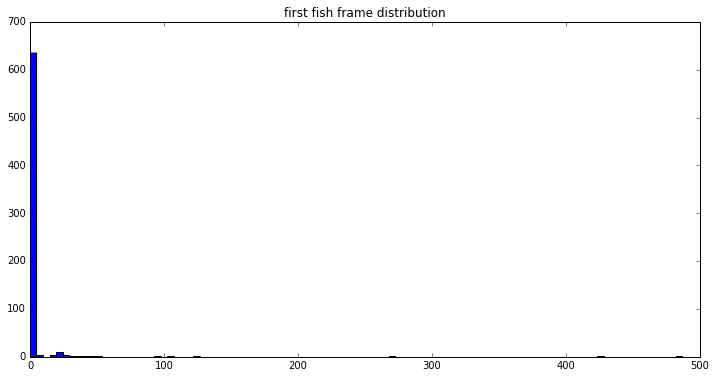

In [25]:
f1 = fish1_frames_list
print 'min', min(f1)
print 'max', max(f1)
plt.figure(figsize=(12,6))
plt.hist(f1, bins=100);
plt.title('first fish frame distribution');

min 1
max 299


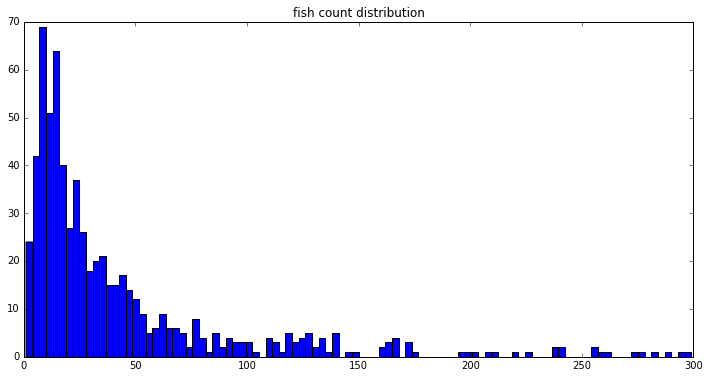

In [26]:
nf = num_fish_map.values()
print 'min', min(nf)
print 'max', max(nf)
plt.figure(figsize=(12,6))
plt.hist(nf, bins=100);
plt.title('fish count distribution');

min 10
max 1315


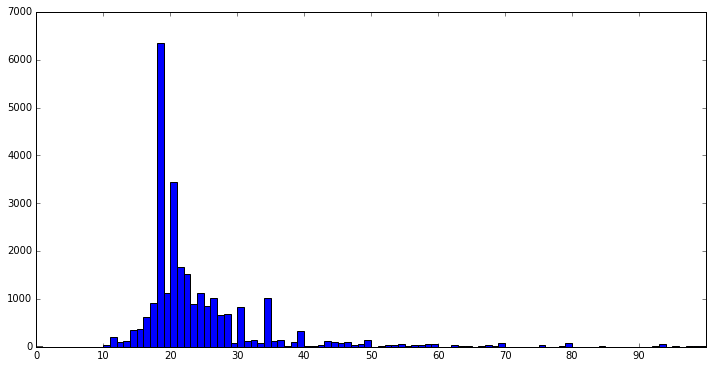

In [27]:
print 'min', min(next_fish_frames_list)
print 'max', max(next_fish_frames_list)
plt.figure(figsize=(12,6))
nbins, ebins, _ = plt.hist(next_fish_frames_list, bins=100, range=[0,100]);
plt.xlim([0,100]);
plt.xticks(range(0,100,10));

In [28]:
# finalize predictions and write csv file

pred_df.row_id = range(pred_df.shape[0])

float_format = '%.6f'

pred_df.to_csv(pjoin('submissions', '{}_fish_number_{}_c.csv'.format(run, fish_number_method)), 
               float_format=float_format,
               index=False)

pred_df.drop(['cx', 'cy'], axis=1)\
.to_csv(pjoin('submissions', '{}_fish_number_{}.csv'.format(run, fish_number_method)), 
        float_format=float_format,
        index=False)